# Web Retrieval and Summarisation

In [33]:
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_ollama import ChatOllama
from typing import TypedDict, Annotated, NotRequired, Literal
import operator
from langgraph.graph import StateGraph, END, START
from IPython.display import Image, display

## Basic Internet Retrieval + Summarisation

In [2]:
search = DuckDuckGoSearchRun() 

model_id = "qwen2.5:0.5b"
llm = ChatOllama(model = model_id,
                num_predict = 256,
                temperature = 0.1)

class BasicState(TypedDict):
    search_query : str 
    search_results : NotRequired[str] 
    history : Annotated[list[str], operator.add]
    summary_content : NotRequired[str]

In [3]:
def retrieval_node(state : BasicState):
    raw_results = search.run(state["search_query"])
    return {
        "search_results" : raw_results,
        "history" : [f"Retrieved : {raw_results[:50]}"]  
    }

def summarizer_node(state : BasicState):
    prompt = f'''
    Summarize the following search results from the internet into clear and concise points.
    Return the points in numbered list format starting from 1.
    #Search Results 

    {state["search_results"]}
    ''' 

    summary = llm.invoke(prompt)
    return {
        'summary_content' : summary.content,
        'history' : ["Summarised search results"]
    }

In [4]:
builder = StateGraph(BasicState)

builder.add_node("retrieve", retrieval_node)
builder.add_node("summarize", summarizer_node)

builder.set_entry_point("retrieve")
builder.add_edge("retrieve", "summarize")
builder.add_edge("summarize", END)

graph = builder.compile()

In [5]:
query = "LEGO Batman 2026 sets"
input = {
    'search_query' : query,
    'history' : []
}

result = graph.invoke(input)

print(result["summary_content"])


Impersonate 'safari_17.4.1' does not exist, using 'random'


- **Batman & Robin Batmobile LEGO set**: Fans can immortalize their love for Batman by owning this set.
- **Batman Logo set**: It includes a logo for the Batman character.
- **Batman v Superman™ Batmobile**: A special edition of the Batman v Superman model.
- **Batman: The Batman Batmobile**: Another special edition of the Batman car.
- **Batman & Robin™ Batmobile**: A special edition of the Batman and Robin car.


# Multi Agent 

In [6]:
search = DuckDuckGoSearchRun() 

model_id = "qwen2.5:0.5b"
llm = ChatOllama(model = model_id,
                num_predict = 256,
                temperature = 0.1)

class BasicState(TypedDict):
    search_query : str 
    search_results : NotRequired[str] 
    history : Annotated[list[str], operator.add]
    summary_content : NotRequired[str]

In [7]:
# One agent for query optimisation and other for summarisation

optimisation_llm = ChatOllama(model = "qwen2.5:0.5b", temperatute = 0.1)
summarizer_llm = ChatOllama(model = "llama3.2:1b", temperature = 0.1)

In [8]:
def research_node(state : BasicState):
    prompt = f'''
    You are a search engine agent. You have to optimise the given query such that it will retrieve rich information when used to browse the internet using a search engine.

    #Search Query

    {state['search_query']}
    '''

    optimized_query = optimisation_llm.invoke(prompt).content
    raw_results = search.run(optimized_query)

    return {
        'search_results' : raw_results, 
        'history' : ['Search done using Brave Browser']
    }

def summarizer_node(state : BasicState):
    prompt = f'''
    Summarize the following search results from the internet into clear and concise points.
    Return the points in numbered list format starting from 1.
    #Search Results 

    {state["search_results"]}
    ''' 

    summary = summarizer_llm.invoke(prompt)
    return {
        'summary_content' : summary.content,
        'history' : ["Summarised search results"]
    }

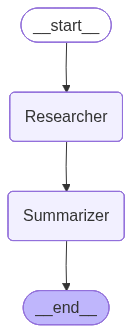

In [9]:
builder = StateGraph(BasicState)

builder.add_node("Researcher", research_node)
builder.add_node("Summarizer", summarizer_node)

#builder.add_edge(START, research_node)
builder.set_entry_point("Researcher")
builder.add_edge("Researcher", "Summarizer")
builder.add_edge("Summarizer", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
query = "LEGO Batman 2026 sets release and description"
input = {
    'search_query' : query,
    'history' : []
}

result = graph.invoke(input)

print(result["summary_content"])

Here are the clear and concise points summarized from the search results:

1. The game "LEGO Batman: Legacy of the Dark Knight" is set to be released on PlayStation 5, Windows, Xbox Series X|S, and Nintendo Switch 2 in May 2026.

2. A version for Nintendo Switch 2 has been scheduled for a later date.

3. The game will feature a "The Dark Knight Returns" Batsuit inspired by the comic series.

4. Curators have reviewed the product and can be found on the website [link].

5. According to the creators, "Legacy of the Dark Knight" will not only be a love letter to Batman's mythology but also a new level for the LEGO series, combining superhero drama with the company's signature humor and family tone.

6. The game is expected to be released in May 2026 on PlayStation 5, Windows, Xbox Series X|S, and Nintendo Switch 2.


## Router deciding between internal knowledge or web search

In [12]:
router_llm = ChatOllama(model = "smollm2:135m",
                        num_predict=20, 
                        temperature=0.2)

assistant_llm = ChatOllama(model="llama3.2:1b", temperature=0.2)

search = DuckDuckGoSearchRun()

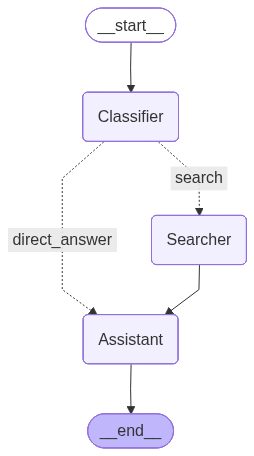

In [27]:
class AgentState(TypedDict):
    content : str 
    history : Annotated[list, operator.add]
    search_needed : bool 
    decision_response : str

def classifier_node(state : AgentState): #Does the query require real time data
    query = state["content"]
    prompt = f'''
    "Does the following query require real-time information or current events ? "
    If you are not aware of the information answer with 'yes'. 
    If you are aware of the answer to the query answer with 'no'. 
    #Query

    {query} 

    "Answer with ONLY 'yes' or 'no'
    '''

    decision = router_llm.invoke(prompt).content.strip().lower() 
    is_search = ''
    if 'yes' or 'requires real time' in decision:
        is_search = True 
    else:
        is_search = False 

    return {
        "search_needed" : is_search, 
        'history' : [f"Decision made is : Search Needed {is_search}"],
        'decision_response' : decision
    }

def search_node(state : AgentState):
    raw_results = search.run(state['content'])
    return {
        'content' : raw_results, 
        'history' : ["Performed Web Search"]
    }

def answer_node(state : AgentState):
    prompt = ''
    if state["search_needed"]:
        prompt = f''' Summarize thes search results into top 3 smart points. 
        The points should encompass all the critical information about the topics being searched.  
        
        # Search Results 

        {state["content"]}
        ''' 

    else:
        prompt = f''' Answer this question using your own knowledge : 
        
        Question : {state["content"]}
        ''' 
    response = assistant_llm.invoke(prompt).content
    return {
        'content' : response, 
        'history' : ['Generated final response']
    }

def decide_next_step(state : AgentState):
    if state["search_needed"]:
        return "search" 
    else:
        return "direct_answer" 

builder = StateGraph(AgentState) 

builder.add_node("Classifier", classifier_node)
builder.add_node("Searcher", search_node)
builder.add_node("Assistant", answer_node)

builder.add_edge(START, "Classifier")

builder.add_conditional_edges(
    "Classifier",
    decide_next_step, 
    {
        "search" : "Searcher", 
        "direct_answer" : "Assistant"
    }
)

builder.add_edge("Searcher", "Assistant")
builder.add_edge("Assistant", END)

graph = builder.compile() 

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
input = {"content": "Why is the sky blue?", "history": []} 
results = graph.invoke(input)
print(results["content"])
print("Decision made was \n", results["decision_response"])

Based on the search results, here are the top 3 smart points that summarize the critical information about the topics being searched:

1. **The sky appears blue due to Rayleigh scattering**: The process of scattering sunlight by small particles in the atmosphere, such as air molecules, causes the light to scatter and become distributed throughout the visible spectrum, resulting in a blue appearance.

2. **Multiple colors are present in sunlight**: Sunlight is composed of all colors of the visible spectrum, including red, orange, yellow, green, blue, indigo, and violet. When these different colors interact with the atmosphere, they scatter and combine to produce the blue color we see in the sky.

3. **The color of the sky depends on the scattering process**: The specific color of the sky is determined by which type of light (e.g., red, orange, yellow) is scattered more than others. In this case, the shorter wavelength (violet) is scattered less and appears blue, while longer wavelengths

In [31]:
input = {"content": "Who wan the ICC T20 World cup match on 21 February 2026", "history": []} 
results = graph.invoke(input)
print(results["content"])
print("Decision made was \n", results["decision_response"])

Here are the top 3 smart points summarizing the search results:

1. **Schedule and Updates**: The ICC Men's T20 World Cup 2026 schedule, including fixtures and results, is available on ESPN.com and Sky Sports for live coverage between February 7 and March 8.
2. **Live Coverage**: Fans can catch the tournament in full on Sky Sports, with real-time updates, ball-by-ball commentary, and fast-paced scores to keep them engaged throughout the competition.
3. **Global and Domestic Series**: The search results highlight that the ICC Men's T20 World Cup 2026 will feature a mix of international and domestic games, including T20, ODI, and Test formats, providing a comprehensive coverage of cricket across various levels.
Decision made was 
 "yes.


## Self correcting node

In [32]:
router_llm = ChatOllama(model = "smollm2:135m",
                        num_predict=20, 
                        temperature=0.2)

assistant_llm = ChatOllama(model="llama3.2:1b", temperature=0.2)

search = DuckDuckGoSearchRun()

* What about a feedback or checker node. 
* Node will check if the answer is generated internally or through a searcg results. If generated from the search results it compares the summary to the raw search results.
* If errors/discrepancies found it will send it back to the assistant with instructions to fix it. 

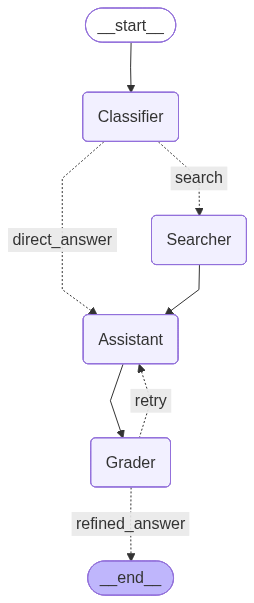

In [36]:
class AgentState(TypedDict):
    content : str 
    history : Annotated[list, operator.add]
    search_needed : bool 
    decision_response : str

def classifier_node(state : AgentState): #Does the query require real time data
    query = state["content"]
    prompt = f'''
    "Does the following query require real-time information or current events ? "
    If you are not aware of the information answer with 'yes'. 
    If you are aware of the answer to the query answer with 'no'. 
    #Query

    {query} 

    "Answer with ONLY 'yes' or 'no'
    '''

    decision = router_llm.invoke(prompt).content.strip().lower() 
    is_search = ''
    if 'yes' or 'requires real time' in decision:
        is_search = True 
    else:
        is_search = False 

    return {
        "search_needed" : is_search, 
        'history' : [f"Decision made is : Search Needed {is_search}"],
        'decision_response' : decision
    }

def search_node(state : AgentState):
    raw_results = search.run(state['content'])
    return {
        'content' : raw_results, 
        'history' : ["Performed Web Search"]
    }

def answer_node(state : AgentState):
    prompt = ''
    if state["search_needed"]:
        prompt = f''' Summarize thes search results into top 3 smart points. 
        The points should encompass all the critical information about the topics being searched.  
        
        # Search Results 

        {state["content"]}
        ''' 

    else:
        prompt = f''' Answer this question using your own knowledge : 
        
        Question : {state["content"]}
        ''' 
    response = assistant_llm.invoke(prompt).content
    return {
        'content' : response, 
        'history' : ['Generated final response']
    }

def decide_next_step(state : AgentState):
    if state["search_needed"]:
        return "search" 
    else:
        return "direct_answer" 
    
def grader_node(state : AgentState):
    if not state["search_needed"]:
        return {
            'history' : ['Skipping Grade : Internal Knowledge Used']
        }
    summary = state["content"]
    raw_data = 'placeholder to change the state to save the raw results too'
    prompt = "Put the summary and raw results and check if there are any factual issues" 
    
    grade = router_llm.invoke(prompt).content.strip().upper() 
    return {
        "history": [f"Grade : {grade}"]
            }

def decide_if_corrected(state : AgentState) -> Literal["refined_answer", "retry"]:
    last_grade = state["history"][-1]
    if "CLEAN" in last_grade or "skipping" in last_grade:
        return "refined_answer"
    return "retry" 
            

builder = StateGraph(AgentState) 

builder.add_node("Classifier", classifier_node)
builder.add_node("Searcher", search_node)
builder.add_node("Assistant", answer_node)
builder.add_node("Grader", grader_node)

builder.add_edge(START, "Classifier")

builder.add_conditional_edges(
    "Classifier",
    decide_next_step, 
    {
        "search" : "Searcher", 
        "direct_answer" : "Assistant"
    }
)

builder.add_edge("Searcher", "Assistant")
builder.add_edge("Assistant", "Grader")

builder.add_conditional_edges(
    "Grader", 
    decide_if_corrected, 
    {
        "refined_answer" : END, 
        "retry" : "Assistant"
    }
)

graph = builder.compile() 

display(Image(graph.get_graph().draw_mermaid_png()))